# Step 00: Data Preparation

There are several versions of data files were created:

* all_data.csv - simply merged version from the raw data

* g20_df.csv - data for G20 countries are filtered from all_data.csv

* lag_df.csv - time lag applied to all_data.csv

* g7_lag_df.csv - G7 countries (Including China and India, but excluding EU), time lag applied

* g20_lag_df.csv - G20 countries (Except EU) filtering and time lag applied to all_data.csv

* lag_three_sel_1969_df - US, China, India are filtered from lag_df and set the starting year 1969 and the end year 2022 due to the data continuity

## Summary
Since the raw data are from two different sources, merging the data into one dataframe is needed.

we set the time lag as 4, (col [t], col_lag1 [t-1], col_lag2 [t-2], col_lag3 [t-3], col_lag4 [t-4]), this would help identify temporal dependencies and give ability to be used for AutoRegressive models.



In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import pickle
import os
import warnings
warnings.filterwarnings("ignore")

# Data load
df_co2 = pd.read_csv("https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv")
df_energy = pd.read_csv("https://raw.githubusercontent.com/owid/energy-data/refs/heads/master/owid-energy-data.csv")

### Data merge

In [2]:
common_columns = set(df_co2.columns).intersection(set(df_energy.columns))
print(common_columns)

{'primary_energy_consumption', 'iso_code', 'population', 'energy_per_capita', 'gdp', 'energy_per_gdp', 'country', 'year'}


In [3]:
# G7 and G20 countries
g7_countries = ['United States', 'China', 'India', 'Canada', 'France', 'Germany', 'Italy', 'Japan', 'United Kingdom']
g20_countries = [
    'United States', 'China', 'Japan', 'Germany', 
    'United Kingdom', 'France', 'Italy', 'Canada',
    'Brazil', 'Russia', 'India', 'Australia', 
    'Mexico', 'Indonesia', 'Turkey', 'Saudi Arabia',
    'South Africa', 'Argentina', 'South Korea'
]

# Remove iso_code from the common columns
common_cols = list(common_columns)
common_cols.remove('iso_code')

# Merge keys
merge_keys = ['country', 'year']

# Unique columns in each dataframe
remain_common_cols = [col for col in common_cols if col not in merge_keys]
df_co2_unique_cols = list(set(df_co2.columns) - set(df_energy.columns) - set(merge_keys))
df_energy_unique_cols = list(set(df_energy.columns) - set(df_co2.columns) - set(merge_keys))
overlap_cols = list(set(df_co2.columns).intersection(set(df_energy.columns)) - set(common_cols) - set(merge_keys))

# Dataframe with unique rows
df_co2_clean = df_co2.drop_duplicates(merge_keys)
df_energy_clean = df_energy.drop_duplicates(merge_keys)

# Merge common cols and unique cols
col_co2 = remain_common_cols + df_co2_unique_cols
col_energy = df_energy_unique_cols

# Common cols appear once
merged_df = pd.merge(
    df_co2_clean[merge_keys + col_co2], 
    df_energy_clean[merge_keys + col_energy],
    on=merge_keys, 
    how='outer'
)

# Overlapping cols not in common cols
if overlap_cols:
    for col in overlap_cols:
        # Temp cols
        co2_data = df_co2_clean[merge_keys + [col]].rename(columns={col: f"{col}_co2"})
        energy_data = df_energy_clean[merge_keys + [col]].rename(columns={col: f"{col}_energy"})

        merged_df = merged_df.merge(co2_data, on=merge_keys, how='left')
        merged_df = merged_df.merge(energy_data, on=merge_keys, how='left')

        merged_df[col] = merged_df[f"{col}_co2"].combine_first(merged_df[f"{col}_energy"])

        # Drop temp cols
        merged_df = merged_df.drop([f"{col}_co2", f"{col}_energy"], axis=1)

df = merged_df.drop(['iso_code'], axis=1).copy()
g7_df = df[df['country'].isin(g7_countries)].copy()
g20_df = df[df['country'].isin(g20_countries)].copy()

# Clean up
del df_co2, df_energy, merged_df, df_co2_clean, df_energy_clean

In [4]:
sorted(g7_df['country'].unique())

['Canada',
 'China',
 'France',
 'Germany',
 'India',
 'Italy',
 'Japan',
 'United Kingdom',
 'United States']

In [5]:
sorted(g20_df['country'].unique())

['Argentina',
 'Australia',
 'Brazil',
 'Canada',
 'China',
 'France',
 'Germany',
 'India',
 'Indonesia',
 'Italy',
 'Japan',
 'Mexico',
 'Russia',
 'Saudi Arabia',
 'South Africa',
 'South Korea',
 'Turkey',
 'United Kingdom',
 'United States']

In [6]:
save_dir = 'data'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

all_data_df = df.copy()
all_data_df.to_csv(os.path.join(save_dir, "all_data_df.csv"), index=False)
g7_df.to_csv(os.path.join(save_dir, "g7_df.csv"), index=False)
g20_df.to_csv(os.path.join(save_dir, "g20_df.csv"), index=False)

In [7]:
# Time lag feature
def time_lag_feature(df, periods=[1, 2, 3, 4]):

    dup_df = df.copy()

    # All numerical columns except year
    feature_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'year' in feature_columns:
        feature_columns.remove('year')

    if 'country' in dup_df.columns and 'year' in dup_df.columns:
        dup_df = dup_df.sort_values(['country', 'year'])

    for country, country_data in dup_df.groupby('country'):
        for col in feature_columns:
            if col in country_data.columns:
                for lag in periods:
                    lag_col_name = f"{col}_lag{lag}"
                    dup_df.loc[country_data.index, lag_col_name] = country_data[col].shift(lag)

    return dup_df

In [8]:
numerical_features = g20_df.select_dtypes(include=[np.number]).columns.tolist()
if 'year' in numerical_features:
    numerical_features.remove('year')

lag_df = all_data_df[['country', 'year'] + numerical_features].copy()
g7_lag_df = g7_df[['country', 'year'] + numerical_features].copy()
g20_lag_df = g20_df[['country', 'year'] + numerical_features].copy()

lag_df = time_lag_feature(lag_df, [1, 2, 3, 4])
g7_lag_df = time_lag_feature(g7_lag_df, [1, 2, 3, 4])
g20_lag_df = time_lag_feature(g20_lag_df, [1, 2, 3, 4])

In [9]:
lag_df.tail(3)

,country,year,primary_energy_consumption,population,energy_per_capita,gdp,energy_per_gdp,coal_co2,share_global_other_co2,temperature_change_from_n2o,...,other_renewable_exc_biofuel_electricity_lag3,other_renewable_exc_biofuel_electricity_lag4,energy_cons_change_twh_lag1,energy_cons_change_twh_lag2,energy_cons_change_twh_lag3,energy_cons_change_twh_lag4,coal_share_elec_lag1,coal_share_elec_lag2,coal_share_elec_lag3,coal_share_elec_lag4
55526,Zimbabwe,2022,NaN,16069061.0,NaN,2.590159e+10,NaN,6.516,NaN,0.0,...,0.0,0.0,4.050,-6.179,-3.804,5.077,29.288,40.835,47.759,43.796
55527,Zimbabwe,2023,NaN,16340829.0,NaN,NaN,NaN,7.271,NaN,0.0,...,0.0,0.0,20.744,4.050,-6.179,-3.804,32.662,29.288,40.835,47.759
55528,Zimbabwe,2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,-6.394,20.744,4.050,-6.179,32.491,32.662,29.288,40.835


In [10]:
g7_lag_df.tail(3)

,country,year,primary_energy_consumption,population,energy_per_capita,gdp,energy_per_gdp,coal_co2,share_global_other_co2,temperature_change_from_n2o,...,other_renewable_exc_biofuel_electricity_lag3,other_renewable_exc_biofuel_electricity_lag4,energy_cons_change_twh_lag1,energy_cons_change_twh_lag2,energy_cons_change_twh_lag3,energy_cons_change_twh_lag4,coal_share_elec_lag1,coal_share_elec_lag2,coal_share_elec_lag3,coal_share_elec_lag4
52676,United States,2022,26504.305,341534041.0,78347.914,1.949317e+13,1.36,942.357,8.240,0.011,...,17.87,18.69,1326.434,-1948.100,-190.494,946.832,21.620,19.128,23.205,27.359
52677,United States,2023,26189.199,343477332.0,77027.836,NaN,NaN,776.767,8.248,0.011,...,18.09,17.87,555.682,1326.434,-1948.100,-190.494,19.397,21.620,19.128,23.205
52678,United States,2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.24,18.09,-295.965,555.682,1326.434,-1948.100,15.870,19.397,21.620,19.128


In [11]:
g20_lag_df.tail(3)

,country,year,primary_energy_consumption,population,energy_per_capita,gdp,energy_per_gdp,coal_co2,share_global_other_co2,temperature_change_from_n2o,...,other_renewable_exc_biofuel_electricity_lag3,other_renewable_exc_biofuel_electricity_lag4,energy_cons_change_twh_lag1,energy_cons_change_twh_lag2,energy_cons_change_twh_lag3,energy_cons_change_twh_lag4,coal_share_elec_lag1,coal_share_elec_lag2,coal_share_elec_lag3,coal_share_elec_lag4
52676,United States,2022,26504.305,341534041.0,78347.914,1.949317e+13,1.36,942.357,8.240,0.011,...,17.87,18.69,1326.434,-1948.100,-190.494,946.832,21.620,19.128,23.205,27.359
52677,United States,2023,26189.199,343477332.0,77027.836,NaN,NaN,776.767,8.248,0.011,...,18.09,17.87,555.682,1326.434,-1948.100,-190.494,19.397,21.620,19.128,23.205
52678,United States,2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.24,18.09,-295.965,555.682,1326.434,-1948.100,15.870,19.397,21.620,19.128


In [12]:
lag_df.to_csv(os.path.join(save_dir, "lag_df.csv"), index=False)
g7_lag_df.to_csv(os.path.join(save_dir, "g7_lag_df.csv"), index=False)
g20_lag_df.to_csv(os.path.join(save_dir, "g20_lag_df.csv"), index=False)

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import os

def load_data(save_dir='data'):
    data_files = {
        'all_data_df': os.path.join(save_dir, 'all_data_df.csv'),
        'g20_df': os.path.join(save_dir, 'g20_df.csv'),
        'lag_df': os.path.join(save_dir, 'lag_df.csv'),
        'g20_lag_df': os.path.join(save_dir, 'g20_lag_df.csv'),
        'g7_df': os.path.join(save_dir, 'g7_df.csv'),
        'g7_lag_df': os.path.join(save_dir, 'g7_lag_df.csv')
    }

    dfs = {}
    for name, filepath in data_files.items():
        if os.path.exists(filepath):
            dfs[name] = pd.read_csv(filepath)
            print(f"Loaded {name}: {dfs[name].shape}")
        else:
            print(f"{filepath} not found")
    
    return dfs

In [14]:
data = load_data()
all_data_df = data['all_data_df']
lag_df = data['lag_df']
g7_df = data['g7_df']
g7_lag_df = data['g7_lag_df']
g20_df = data['g20_df']
g20_lag_df = data['g20_lag_df']

Loaded all_data_df: (55529, 200)
Loaded g20_df: (3744, 200)
Loaded lag_df: (55529, 992)
Loaded g20_lag_df: (3744, 992)
Loaded g7_df: (1890, 200)
Loaded g7_lag_df: (1890, 992)


In [15]:
selected_countries = ['United States', 'China', 'India']
lagged_selected_countries_df = lag_df[lag_df['country'].isin(selected_countries)].copy()

In [16]:
def plot_trends(df, target, countries=None):
    plot_df = df.copy()

    plt.figure(figsize=(12, 6))

    for country in plot_df['country'].unique():
        country_data = plot_df[plot_df['country'] == country]
        country_data = country_data.sort_values('year')
        plt.plot(country_data['year'], country_data[target], marker='o', label=country, linewidth=2, markersize=3)

    plt.xlabel('Year', fontsize=12)
    plt.ylabel(target, fontsize=12)
    plt.title(f'{target} Trends by Country', fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

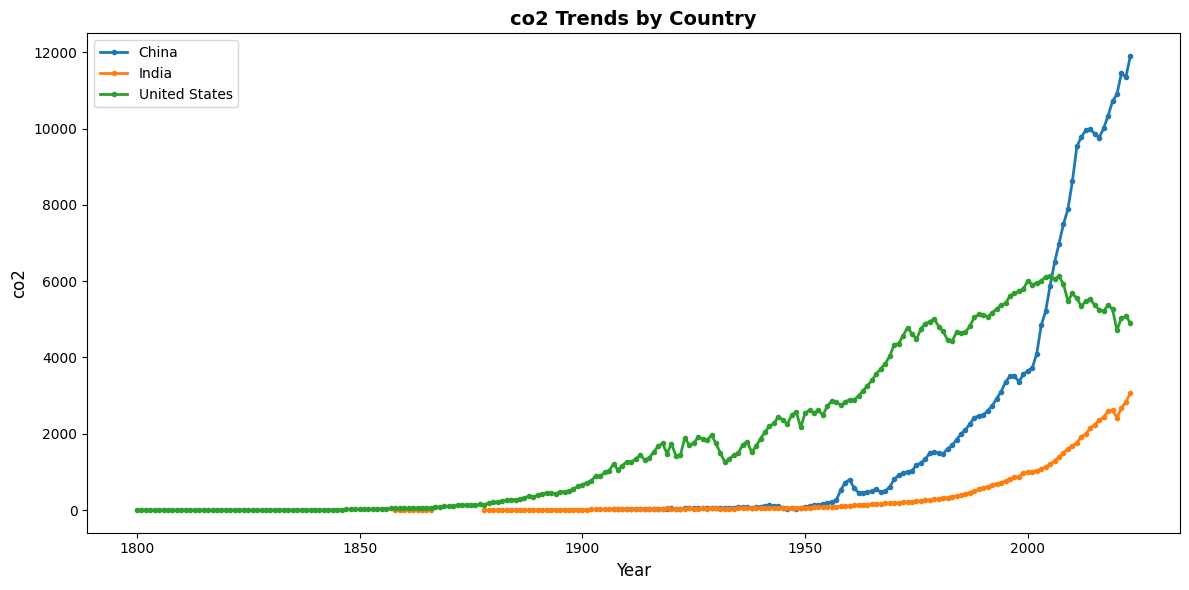

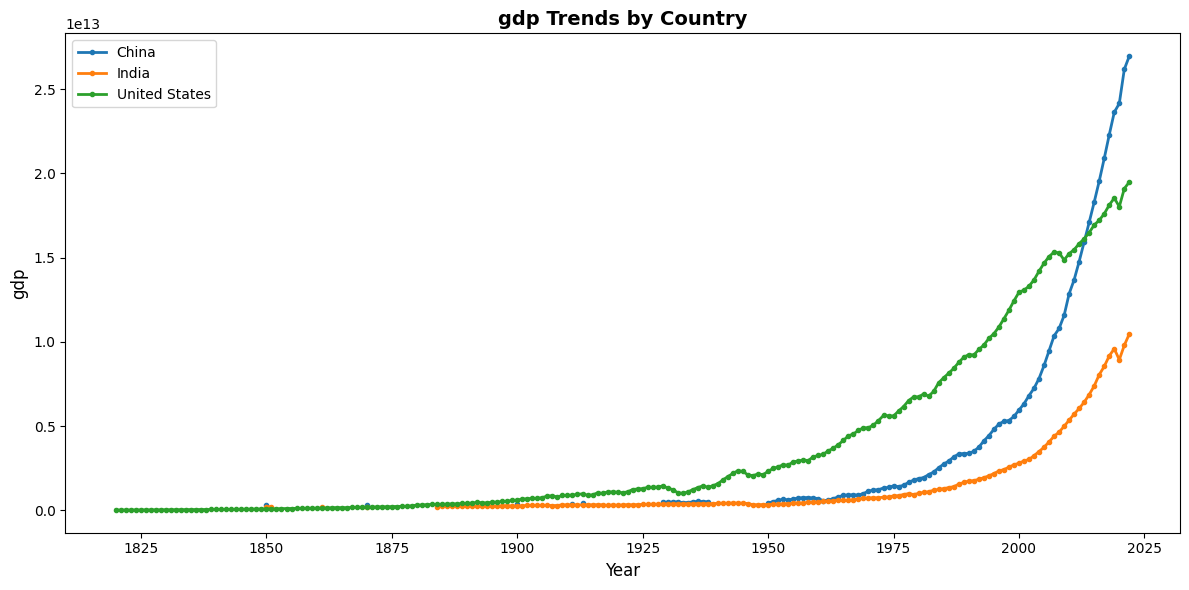

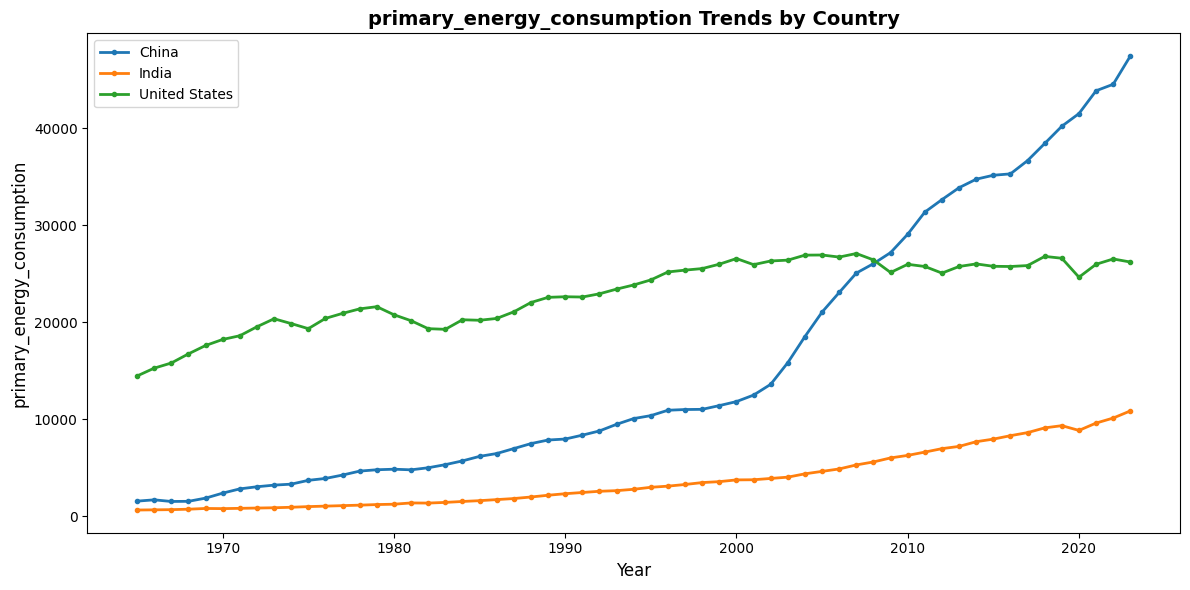

In [17]:
TARGET_VARIABLES = ['co2', 'gdp', 'primary_energy_consumption']
for target in TARGET_VARIABLES:
    plot_trends(lagged_selected_countries_df, target, selected_countries)

In [18]:
def check_start_year(df, target, countries=None):
    check_df = df.copy()
    if countries is not None:
        check_df = check_df[check_df['country'].isin(countries)]

    start_years = []

    for country in check_df['country'].unique():
        country_data = check_df[check_df['country'] == country]

        valid_data = country_data[country_data[target].notna()]

        if len(valid_data) > 0:
            start_year = valid_data['year'].min()
            end_year = valid_data['year'].max()
            data_points = len(valid_data)
        else:
            start_year = None
            end_year = None
            data_points = 0

        start_years.append({
            'country': country,
            'target': target,
            'start_year': start_year,
            'end_year': end_year,
            'data_points': data_points
        })
    
    result_df = pd.DataFrame(start_years)
    result_df = result_df.sort_values('start_year')
    
    return result_df

In [19]:
check_start_year(lagged_selected_countries_df, 'primary_energy_consumption', selected_countries)

,country,target,start_year,end_year,data_points
0,China,primary_energy_consumption,1965,2023,59
1,India,primary_energy_consumption,1965,2023,59
2,United States,primary_energy_consumption,1965,2023,59


In [20]:
check_start_year(all_data_df, 'primary_energy_consumption', selected_countries)

,country,target,start_year,end_year,data_points
0,China,primary_energy_consumption,1965,2023,59
1,India,primary_energy_consumption,1965,2023,59
2,United States,primary_energy_consumption,1965,2023,59


In [21]:
lag_three_1969_df = lagged_selected_countries_df[lagged_selected_countries_df['year'] >= 1969].copy()

In [22]:
check_start_year(lag_three_1969_df, 'primary_energy_consumption', selected_countries)

,country,target,start_year,end_year,data_points
0,China,primary_energy_consumption,1969,2023,55
1,India,primary_energy_consumption,1969,2023,55
2,United States,primary_energy_consumption,1969,2023,55


In [23]:
check_start_year(lag_three_1969_df, 'primary_energy_consumption_lag1', selected_countries)

,country,target,start_year,end_year,data_points
0,China,primary_energy_consumption_lag1,1969,2024,56
1,India,primary_energy_consumption_lag1,1969,2024,56
2,United States,primary_energy_consumption_lag1,1969,2024,56


In [24]:
check_start_year(lag_three_1969_df, 'primary_energy_consumption_lag2', selected_countries)

,country,target,start_year,end_year,data_points
0,China,primary_energy_consumption_lag2,1969,2024,56
1,India,primary_energy_consumption_lag2,1969,2024,56
2,United States,primary_energy_consumption_lag2,1969,2024,56


In [25]:
check_start_year(lag_three_1969_df, 'co2', selected_countries)

,country,target,start_year,end_year,data_points
0,China,co2,1969,2023,55
1,India,co2,1969,2023,55
2,United States,co2,1969,2023,55


In [26]:
check_start_year(lag_three_1969_df, 'gdp', selected_countries)

,country,target,start_year,end_year,data_points
0,China,gdp,1969,2022,54
1,India,gdp,1969,2022,54
2,United States,gdp,1969,2022,54


In [27]:
lag_three_sel_years_df = lag_three_1969_df[lag_three_1969_df['year'] < 2023].copy()

In [28]:
check_start_year(lag_three_sel_years_df, 'primary_energy_consumption', selected_countries)

,country,target,start_year,end_year,data_points
0,China,primary_energy_consumption,1969,2022,54
1,India,primary_energy_consumption,1969,2022,54
2,United States,primary_energy_consumption,1969,2022,54


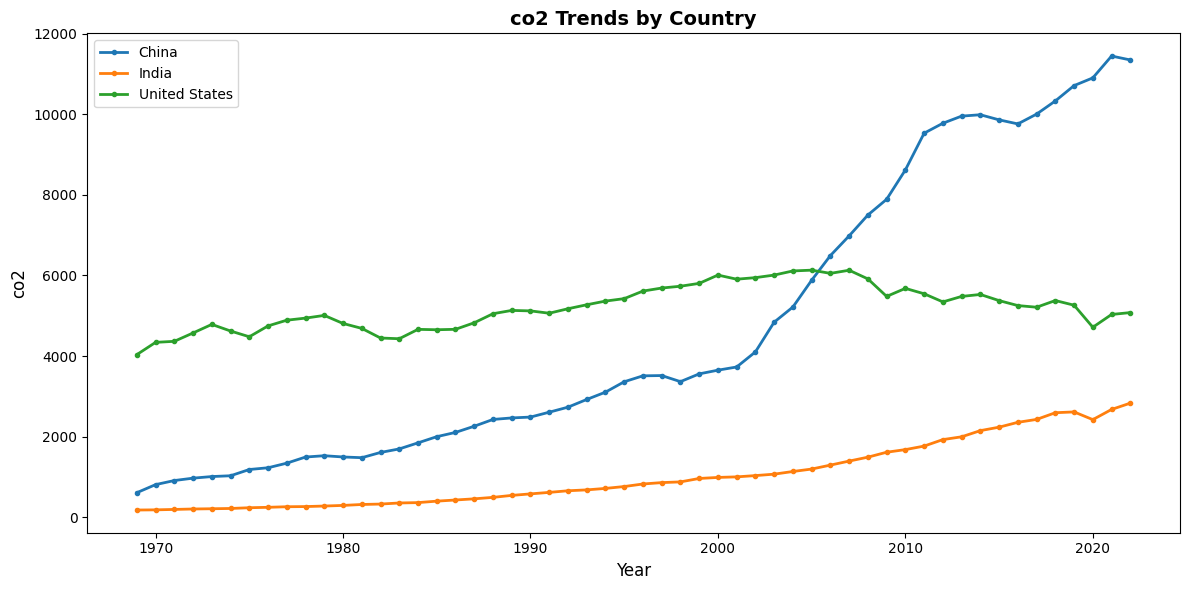

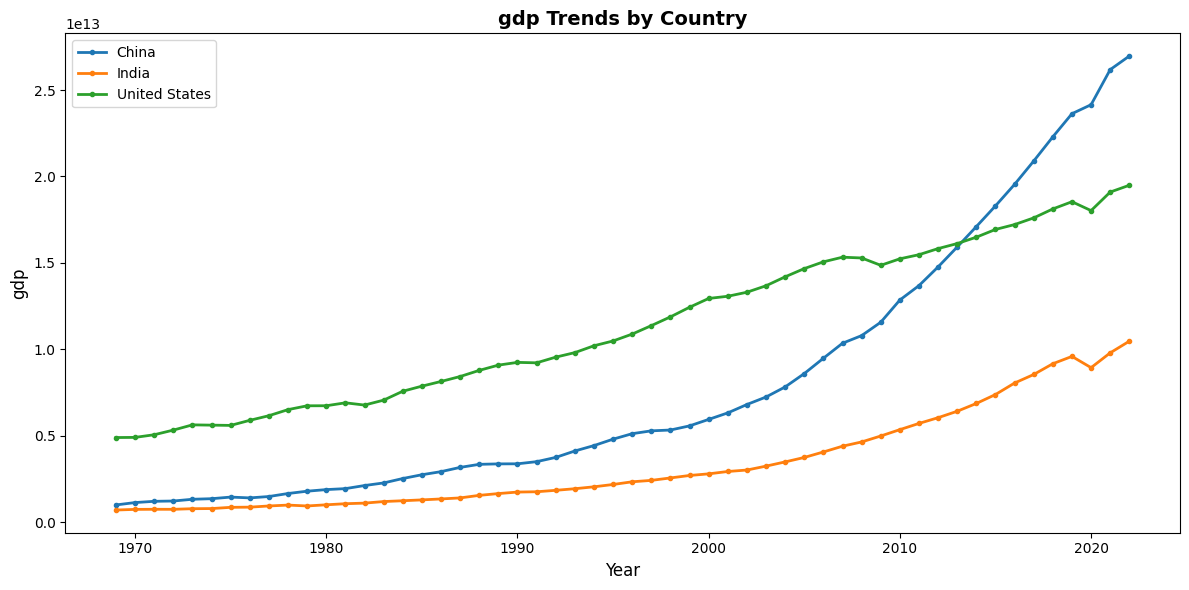

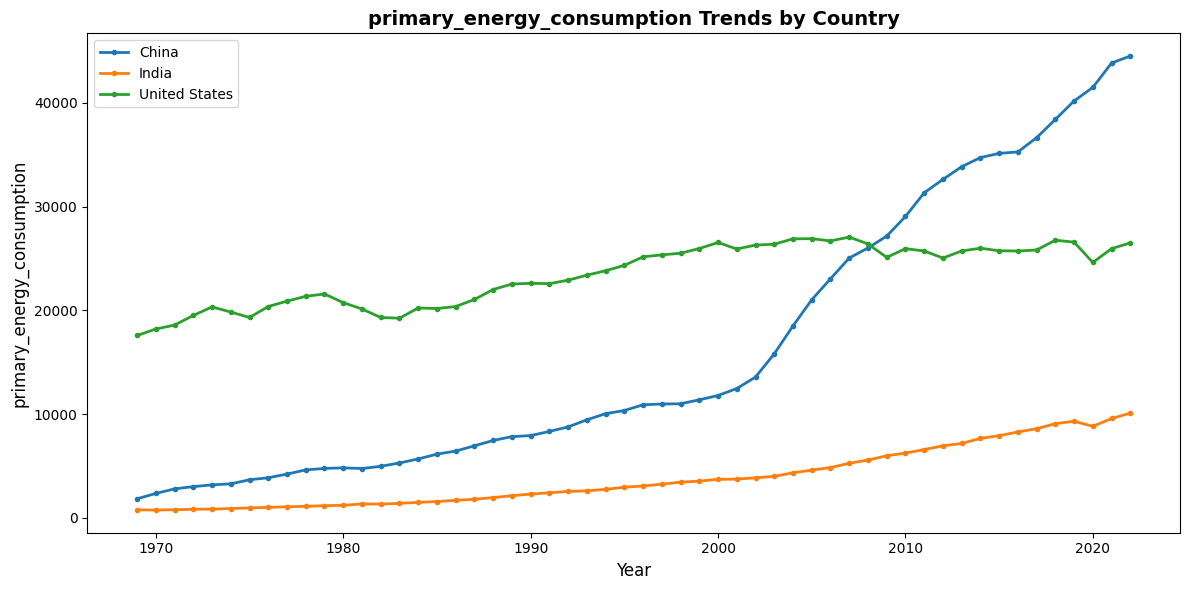

In [29]:
for target in TARGET_VARIABLES:
    plot_trends(lag_three_sel_years_df, target, selected_countries)

In [30]:
save_dir = 'data'
lag_three_sel_years_df.to_csv(os.path.join(save_dir, 'lag_three_sel_1969_df.csv'), index=False)